<a href="https://colab.research.google.com/github/fundottz/ml-baby-sleep/blob/main/Baby_sleep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Новый раздел

Примеры формулировок проблем для решения:
1. Рассчитать среднюю норму сна в сутки из расчета минимального значения плача (Какой алгоритм?
2. Спрогнозировать, каким будет текущий сон ребенка - S/M/L, чтобы понимать в какие часы, что можно делать. Задача кластеризации, алгоритм K-Means
3. Рекомендательная система, какая последовательность событий должна следовать от текущего момента, чтобы ребенок нормально спал ночью или следующий сон был длинный. 
4. Multi-feature regression 

Построить надо регрессию нормальную с графиком и градиентным спуском для подбора параметров. 
Разделять выборки по неделям. 

In [67]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the data
filename='/content/drive/MyDrive/ml-data/baby-data-2604.csv'
cols_to_use = [0, 2, 3, 5]
cols_names = ['activity', 'start_time', 'end_time', 'duration']
data = pd.read_csv(filename, sep=";", skiprows=1, usecols=cols_to_use, names = cols_names)

# Convert start time and end time to datetime objects
data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])
data['duration'] = data['duration'].str.replace(',', '.').astype(float)

# Extract extra-features: the week day and start hour
data['day'] = data['start_time'].dt.dayofweek
data['hour'] = data['start_time'].dt.hour

# Check data
data.head()

,activity,start_time,end_time,duration,day,hour
0,Кормление,2023-04-26 17:23:26,2023-04-26 17:27:14,0.063504,2,17
1,Сон,2023-04-26 16:56:02,2023-04-26 17:23:26,0.456504,2,16
2,Сон,2023-04-26 16:52:07,2023-04-26 16:56:02,0.065246,2,16
3,Бодрствование,2023-04-26 15:42:10,2023-04-26 16:52:07,1.165808,2,15
4,Сон,2023-04-26 15:40:39,2023-04-26 15:42:10,0.025381,2,15


Разметка данных для обучения

In [83]:
# Create a dictionary that maps the unique string values to integers
#mapping = {}
#for i, value in enumerate(data['activity'].unique()):
#    mapping[value] = i

# Replace the string values with the corresponding integers
#data['activity'] = data['activity'].replace(mapping)

# Clean data: delete activities less 1 minute
data.drop(data[data.duration < 5/60].index, inplace=True)

sleep_data = data[data['activity']=='Сон']

print(sleep_data.head())
features = ["day","hour"]
output = 'duration'

# USE ONLY SLEEP DATA
X = sleep_data[features].values
y = sleep_data[output].values

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

   activity          start_time            end_time  duration  day  hour
1       Сон 2023-04-26 16:56:02 2023-04-26 17:23:26  0.456504    2    16
6       Сон 2023-04-26 14:50:17 2023-04-26 15:02:50  0.209191    2    14
9       Сон 2023-04-26 12:56:29 2023-04-26 14:44:52  1.806363    2    12
21      Сон 2023-04-26 10:21:20 2023-04-26 10:59:00  0.627801    2    10
23      Сон 2023-04-26 08:32:30 2023-04-26 08:39:34  0.118003    2     8


Визуализация

Data for the period: 2023-04-05 15:42:10 - 2023-04-26 15:42:10 


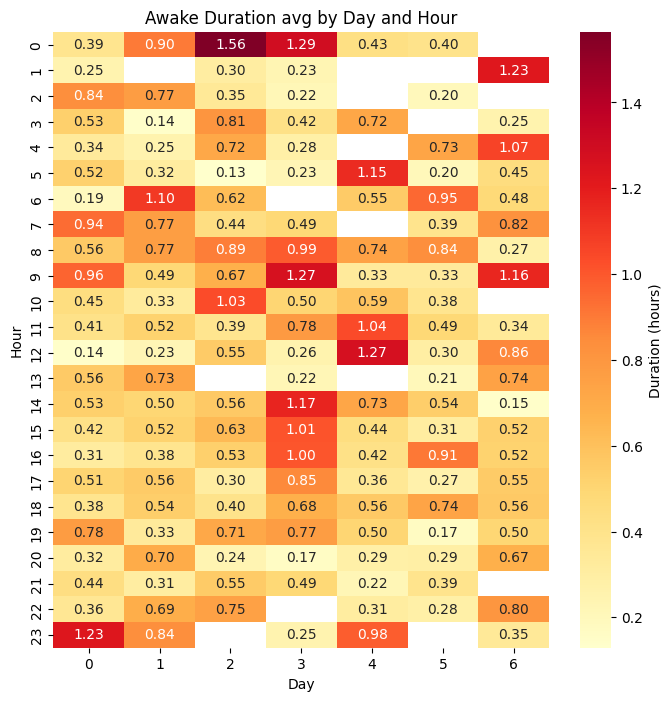

Data for the period: 2023-04-19 15:42:10 - 2023-04-26 15:42:10 


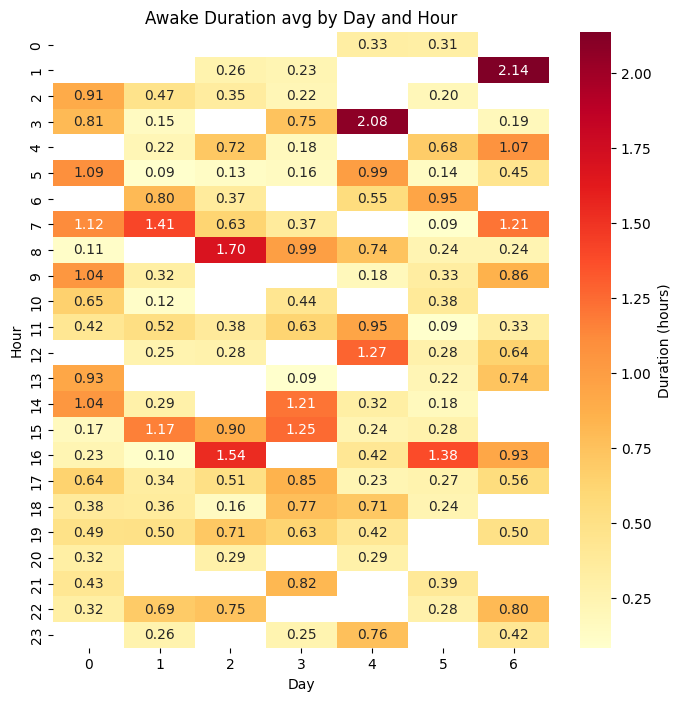

Data for the period: 2023-04-12 15:42:10 - 2023-04-19 15:42:10 


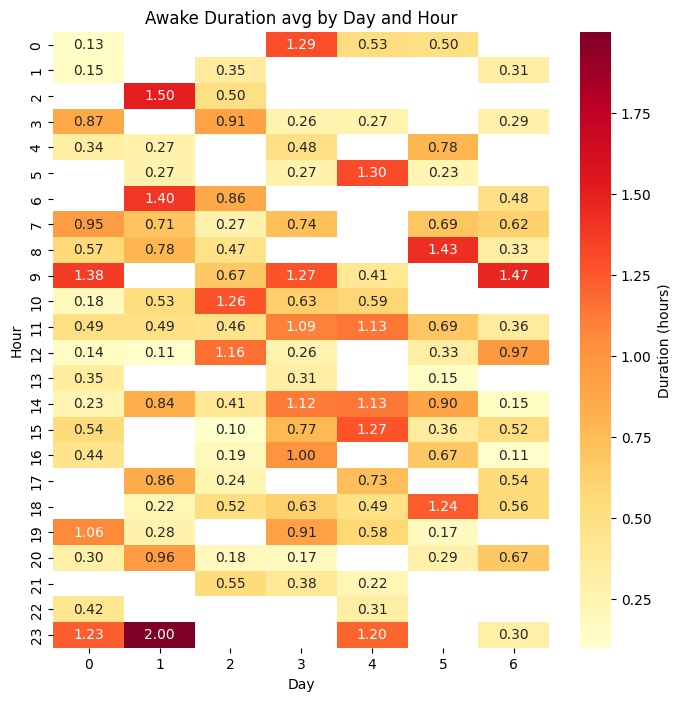

Data for the period: 2023-04-05 15:42:10 - 2023-04-12 15:42:10 


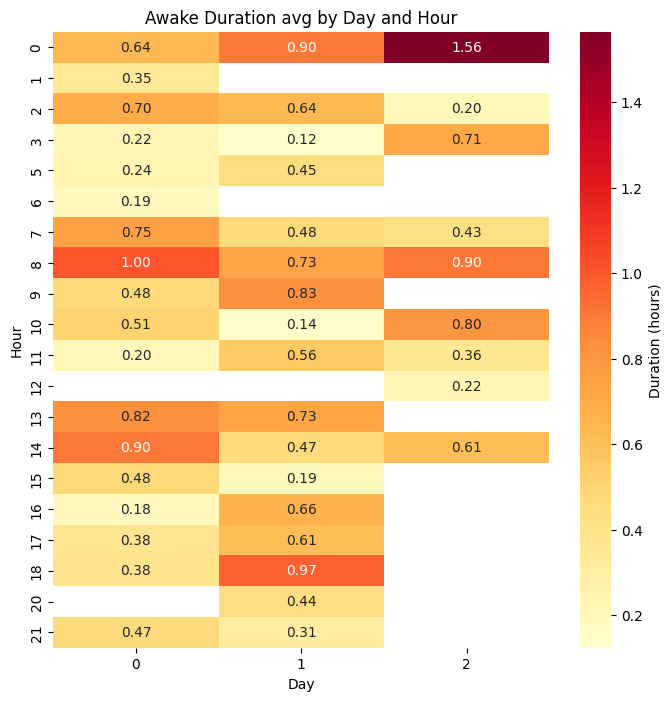

In [82]:
import datetime as dt
import seaborn as sns

def plot(start_date, end_date, data):
  # take slice with final week of data
  week_data = data[(data['start_time'] >= week_before) & 
               (data['start_time'] <= last_date)]
  print(f'Data for the period: {week_before} - {last_date} ')
  week_data = week_data.groupby(['day', 'hour'])['duration'].mean()
  
  # Pivot data to create a 2D table of day and hour values
  pivoted_data = week_data.reset_index().pivot(index='hour', columns='day', values='duration')

  # Create heatmap plot
  fig, ax = plt.subplots(figsize=(8, 8))
  sns.heatmap(pivoted_data, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Duration (hours)'}, ax=ax)

  # Set axis labels and title
  ax.set_xlabel('Day')
  ax.set_ylabel('Hour')
  ax.set_title('Awake Duration avg by Day and Hour')

  # Show plot
  plt.show()



weeks = 3
df = sleep_data
last_date = df['start_time'].max();

plot(df['start_time'].min(), last_date, df)

for i in range(weeks):
  week_before = last_date - dt.timedelta(days=7)
  plot (week_before, last_date, df)
  last_date = week_before

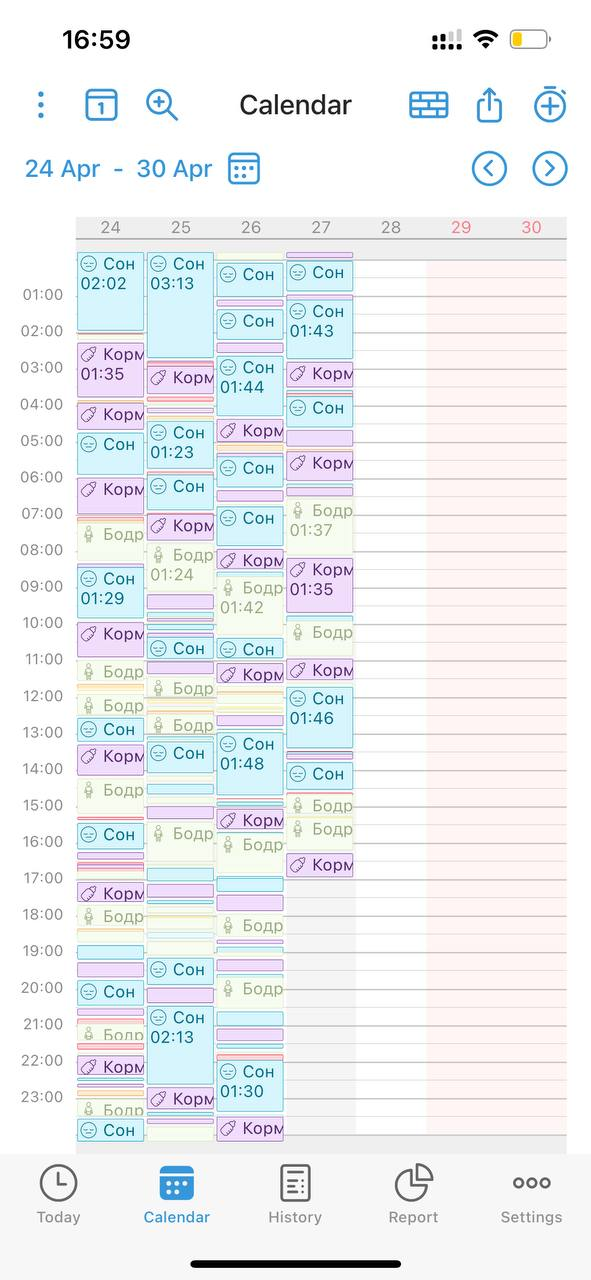

In [ ]:
print(mapping)

# Group the data by day of the week and hour, and calculate the max, min, and average duration for each activity
grouped = data.groupby(['day', 'hour', 'activity']).agg({'duration': ['max', 'min', 'mean']})
# grouped.to_csv('grouped_data.csv')
print(grouped)

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")
print ('We have m = %d training examples' % (len(y_train)))

{'Бодрствование': 0, 'Плач': 1, 'Сон': 2, 'Кормление': 3, 'Выкладывание на живот': 4}
                   duration                    
                        max       min      mean
day hour activity                              
0   0    2         3.581574  1.344555  2.586121
         3         0.639519  0.639519  0.639519
    1    0         0.345360  0.345360  0.345360
         2         1.565254  0.129226  0.718904
         3         0.473313  0.345745  0.409529
...                     ...       ...       ...
6   22   3         0.559309  0.244452  0.416695
         4         0.320347  0.320347  0.320347
    23   0         0.164642  0.164642  0.164642
         2         2.375254  0.104240  0.903716
         3         0.542483  0.191296  0.414801

[644 rows x 3 columns]
the shape of the training set (input) is: (327, 2)
the shape of the training set (target) is: (327,)

the shape of the cross validation set (input) is: (109, 2)
the shape of the cross validation set (target) is: (109,)

Визуал

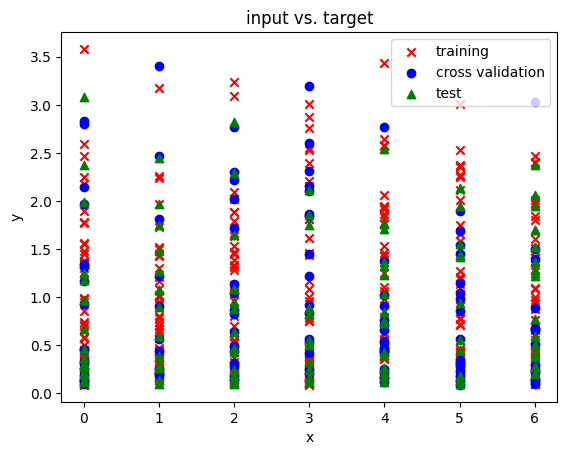

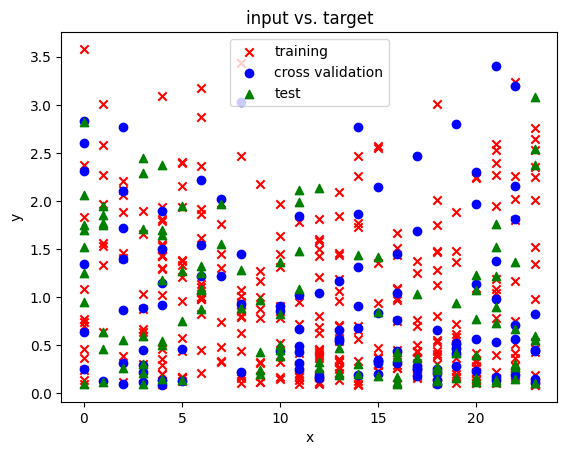

In [ ]:
for i in range(len(features)):
  plt.scatter(x_train[:,i], y_train, marker='x', c='r', label='training'); 
  plt.scatter(x_cv[:,i], y_cv, marker='o', c='b', label='cross validation'); 
  plt.scatter(x_test[:,i], y_test, marker='^', c='g', label='test'); 
  plt.title("input vs. target")
  plt.xlabel("x"); 
  plt.ylabel("y"); 
  plt.legend()
  plt.show()

Пример регрессии из лабы

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
sgdr = SGDRegressor(max_iter=1000)
sgdr.fit(x_train, y_train)
print(sgdr)
print(f"number of iterations completed: {sgdr.n_iter_}, number of weight updates: {sgdr.t_}")

b = sgdr.intercept_
w = sgdr.coef_
print(f"model parameters:                   w: {w}, b:{b}")
print("------------------")



# make a prediction using sgdr.predict()
y_pred_sgd = sgdr.predict(x_train)
# make a prediction using w,b. 
y_pred = np.dot(x_train, w) + b  
print(f"prediction using np.dot() and sgdr.predict match: {(y_pred == y_pred_sgd).all()}")

print(f"Prediction on training set:\n{y_pred[:4]}" )
print(f"Target values \n{y_train[:4]}")

X_features = ['day', 'hour']

# plot predictions and targets vs original features    
fig,ax=plt.subplots(1,2,figsize=(12,3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(x_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(x_train[:,i],y_pred,color=["orange"], label = 'predict')
ax[0].set_ylabel("duration"); ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()


Линейная регрессия от часа на SKLEARN

[[15]
 [15]
 [15]
 [13]
 [ 9]]
[[0.0290011]
 [0.3423968]
 [0.1795009]
 [0.7042755]
 [1.2694219]]
R^2 Score: -0.07636179963602974


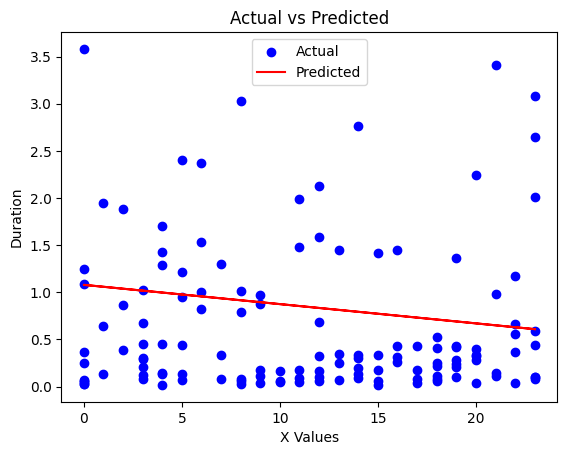

In [ ]:
from sklearn.linear_model import LinearRegression

X = sleep_data['hour'].values.reshape(-1,1)
print(X[:5])
y = sleep_data['duration'].values.reshape(-1,1)
print(y[:5])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

single_model = LinearRegression()
single_model.fit(X_train, y_train)

# evaluate the model on the testing data
score = single_model.score(X_test, y_test)
print('R^2 Score:', score)

y_pred = single_model.predict(X_test)

plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', label='Predicted')
plt.xlabel('X Values')
plt.ylabel('Duration')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

Линейная регрессия от всех фичей на SKLEARN

In [ ]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# evaluate the model on the testing data
score = lr_model.score(X_test, y_test)
print('R^2 Score:', score)

R^2 Score: -0.07636179963602974


Прогноз сна на текущий час


   day  hour
0    0    12
Predicted duration: [0.74054989] hours
Average duration by activity:
day  hour  activity
0    12    0           0.571483
           2           0.056460
Name: (duration, mean), dtype: float64
Where activity mapping:
{'Бодрствование': 0, 'Плач': 1, 'Сон': 2, 'Кормление': 3, 'Выкладывание на живот': 4}


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


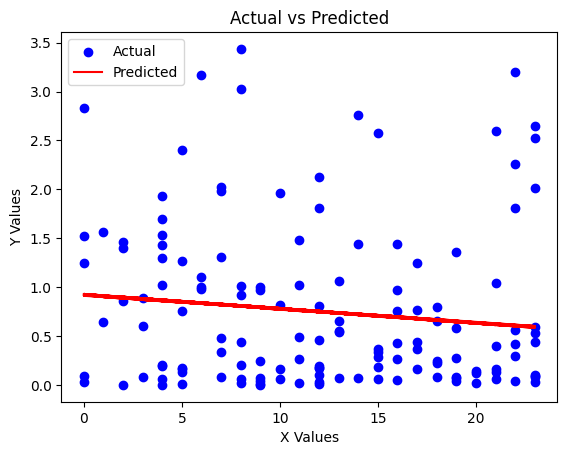

In [ ]:
import datetime
import pytz

# Get the current date and time
now = datetime.datetime.now()

# Set the timezone to Yerevan time
tz = pytz.timezone('Asia/Yerevan')
now_yerevan_time = pytz.utc.localize(now).astimezone(tz)

now = pd.DataFrame({'day': now_yerevan_time.weekday(),
                    'hour': now_yerevan_time.hour,
                    'duration': 0},
                   index=[0])
now = now[['day', 'hour']]
print(now)
prediction = lr_model.predict(now)
print('Predicted duration:', prediction, 'hours')
print('===========')
stat_average = grouped.loc[now['day'], now['hour'], slice(None)]

print('Average duration by activity:')
print(stat_average[('duration', 'mean')])
print('===========')

print('Where activity mapping:')
print(mapping)
y_pred = lr_model.predict(X_test)

plt.scatter(X_test[:,1], y_test, color='blue', label='Actual')
plt.plot(X_test[:,1], y_pred, color='red', label='Predicted')
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

Сложная модель с нейронкой

In [ ]:
model = tf.keras.models.Sequential(
    [               
        tf.keras.Input(shape=(2,)),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(14, activation='softmax'),
        tf.keras.layers.Dense(1, activation='linear')
        
    ], name = "deep_model" 
)
model.summary()   
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), 
    # loss=tf.keras.losses.BinaryCrossentropy()
    loss='mean_squared_error'
    )

model.fit(x_train, y_train, epochs=100)

Model: "deep_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 24)                72        
                                                                 
 dense_12 (Dense)            (None, 14)                350       
                                                                 
 dense_13 (Dense)            (None, 1)                 15        
                                                                 
Total params: 437
Trainable params: 437
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13/13 [==============================] - 1s 2ms/step - loss: 0.9028
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6978
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6928
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6899
Ep

5/5 [==============================] - 0s 3ms/step


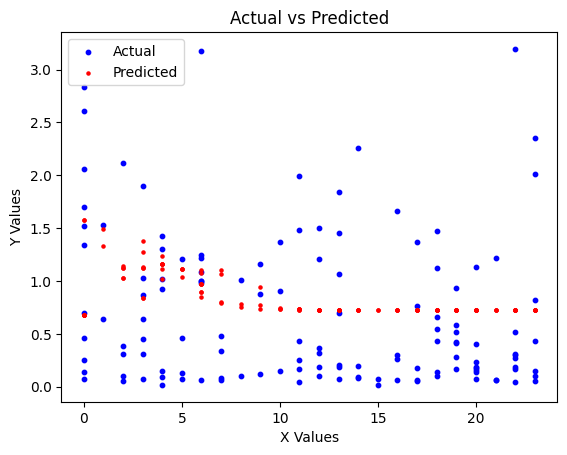

In [ ]:
y_pred = model.predict(x_test)

plt.scatter(x_test[:,1], y_test, color='blue', s=10, label='Actual')
plt.scatter(x_test[:,1], y_pred, color='red', s=5, label='Predicted')
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

Predict

In [ ]:
sunday_23pm = grouped.loc[6, 23, slice(None)]

current = [[6, 23, 0],
           [6, 23, 1],
           [6, 23, 2],
           [6, 23, 3],
           [6, 23, 4],
           ]
p = model.predict(current)
print('Prediction:') 
print(p)

print('Average duration by activity:')
print(sunday_23pm[('duration', 'mean')])

TENSORFLOW

LEARN SIMPLE MODEL, REGRESSION

In [ ]:
hours_train = data['hour'].values

hours_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
hours_normalizer.adapt(hours_train)

hours_model = tf.keras.models.Sequential([
    hours_normalizer,
    tf.keras.layers.Dense(units=1)
])

hours_model.summary()
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense_92 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
!pip install colabcode

In [ ]:
from colabcode import ColabCode
ColabCode(port=10000)

Code Server can be accessed on: NgrokTunnel: "https://ab14-34-138-129-184.ngrok.io" -> "http://localhost:10000"
[2023-04-21T13:52:13.173Z] info  code-server 3.10.2 387b12ef4ca404ffd39d84834e1f0776e9e3c005
[2023-04-21T13:52:13.175Z] info  Using user-data-dir ~/.local/share/code-server
[2023-04-21T13:52:13.209Z] info  Using config file ~/.config/code-server/config.yaml
[2023-04-21T13:52:13.209Z] info  HTTP server listening on http://127.0.0.1:10000 
[2023-04-21T13:52:13.209Z] info    - Authentication is disabled 
[2023-04-21T13:52:13.209Z] info    - Not serving HTTPS 


KeyboardInterrupt: ignored